In [ ]:
!pip install fastai --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
#importing libraries
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate
from pathlib import Path
from collections import Counter
from google.colab import files
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
os.listdir('/content')

['.config', 'archive.zip', 'sample_data']

In [ ]:
zip_path = "/content/archive.zip"  # Update with the actual file name if different
extract_path = "/content/intel_dataset"  # Folder where data will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folders
print(os.listdir(extract_path))

['seg_train', 'seg_test', 'seg_pred']


In [ ]:
train_path = Path("/content/intel_dataset/seg_train/seg_train")
test_path = Path("/content/intel_dataset/seg_test/seg_test")
pred_path = Path("/content/intel_dataset/seg_pred")

# List class folders
print("Training Classes:", train_path.ls())
print("Testing Classes:", test_path.ls())


Training Classes: [Path('/content/intel_dataset/seg_train/seg_train/mountain'), Path('/content/intel_dataset/seg_train/seg_train/buildings'), Path('/content/intel_dataset/seg_train/seg_train/forest'), Path('/content/intel_dataset/seg_train/seg_train/sea'), Path('/content/intel_dataset/seg_train/seg_train/street'), Path('/content/intel_dataset/seg_train/seg_train/glacier')]
Testing Classes: [Path('/content/intel_dataset/seg_test/seg_test/mountain'), Path('/content/intel_dataset/seg_test/seg_test/buildings'), Path('/content/intel_dataset/seg_test/seg_test/forest'), Path('/content/intel_dataset/seg_test/seg_test/sea'), Path('/content/intel_dataset/seg_test/seg_test/street'), Path('/content/intel_dataset/seg_test/seg_test/glacier')]


###Image Data Loader

In [ ]:
# Set random seed for reproducibility
np.random.seed(40)

# Load dataset using fastai v2
dls = ImageDataLoaders.from_folder(
    train_path,  # Use the correct dataset path
    valid_pct=0.2,  # 20% validation split
    seed=40,  # Ensures consistent train/validation split
    item_tfms=Resize(224),  # Resize images to 224x224
    batch_tfms=aug_transforms(),  # Includes normalization automatically
    num_workers=4  # Speed up data loading
)


### Verifying Data Loading

In [ ]:
print(f"Number of Classes: {dls.c}")  # Prints the total number of classes
print(f"Classes: {dls.vocab}")  # List class labels
print(f"Training set size: {len(dls.train_ds)} images")
print(f"Validation set size: {len(dls.valid_ds)} images")


Number of Classes: 6
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training set size: 11228 images
Validation set size: 2806 images


###Data Explorations

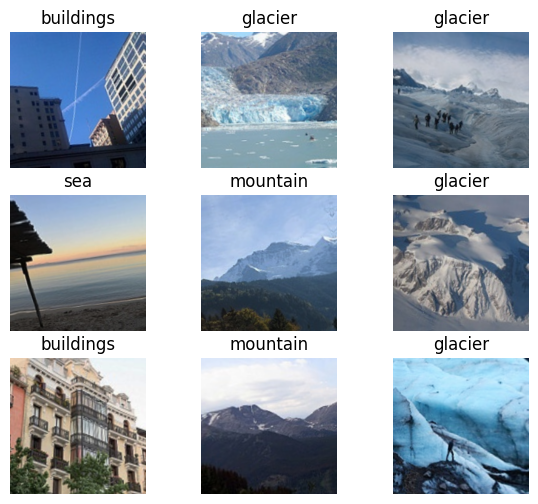

In [ ]:
dls.show_batch(max_n=9, figsize=(7,6))

###Checking Class Distributions:
To see how many images exist in each category - This helps check if the dataset is balanced.



In [ ]:
# Get the class distribution
train_classes = [dls.train_ds.items[i].parent.name for i in range(len(dls.train_ds))]
class_counts = Counter(train_classes)

# Print class distribution
print("Class Distribution in Training Set:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Class Distribution in Training Set:
buildings: 1743 images
glacier: 1935 images
sea: 1816 images
forest: 1817 images
street: 1873 images
mountain: 2044 images


###Visualize Class Distribution Using a Bar Chart

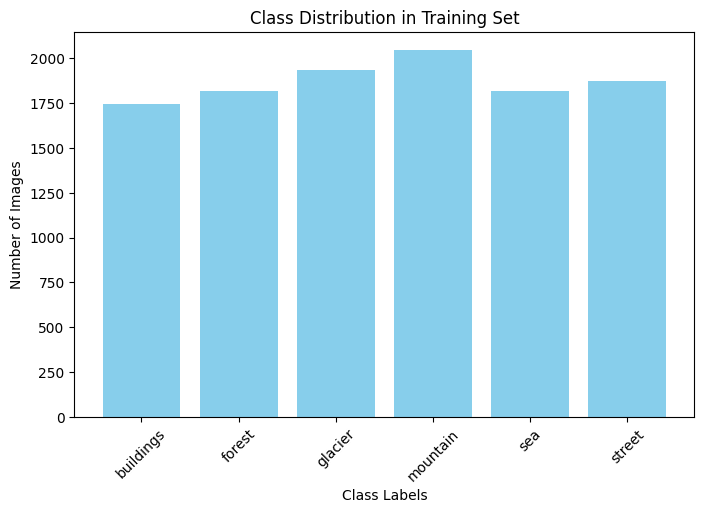

In [ ]:
# Sort labels alphabetically for better visualization
labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()


###Create a CNN Model (ResNet18)

In [ ]:
# Create a model using ResNet18 (pre-trained on ImageNet)
learn = vision_learner(
    dls,  # DataLoaders object
    resnet18,  # Pre-trained model
    metrics=[accuracy],  # Track accuracy
    model_dir=Path("/content/models"),  # Save model inside Colab
    path=Path("."),  # Set the current direcrtory as the working directory
)

# Show model architecture
learn.model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

###Find the Optimal Learning Rate

Optimal LR: SuggestedLRs(valley=0.001737800776027143)


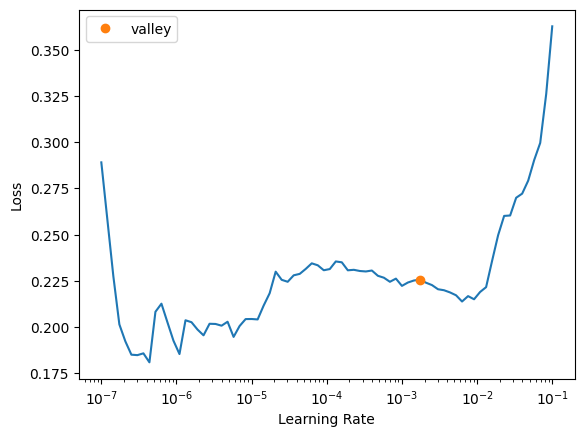

In [ ]:
lr_valley = learn.lr_find()
print(f"Optimal LR: {lr_valley}")

The suggested LR (valley point) is: 0.001737800776027143 ≈ 1.7e-3.
This means the model learns best around 1.7e-3 before loss increases.

###Train the Model (Fine-tune)

In [ ]:
# Define learning rate range based on the optimal LR
lr1 = 1.7e-3  # Suggested valley LR from lr_find()
lr2 = lr1 * 10  # Slightly higher upper bound to allow flexibility

# Train the model for 40 epochs with an optimized learning rate
learn.fit_one_cycle(
    40, slice(lr1, lr2),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)] #This stops training if the model does not improve for 5 epochs.
)


epoch,train_loss,valid_loss,accuracy,time
0,0.211139,0.198223,0.926942,00:47
1,0.221418,0.200675,0.927299,00:47
2,0.247024,0.231605,0.921953,00:48
3,0.281921,0.242086,0.924448,00:47
4,0.275070,0.231737,0.926942,00:48
5,0.284642,0.234959,0.920171,00:48


No improvement since epoch 0: early stopping


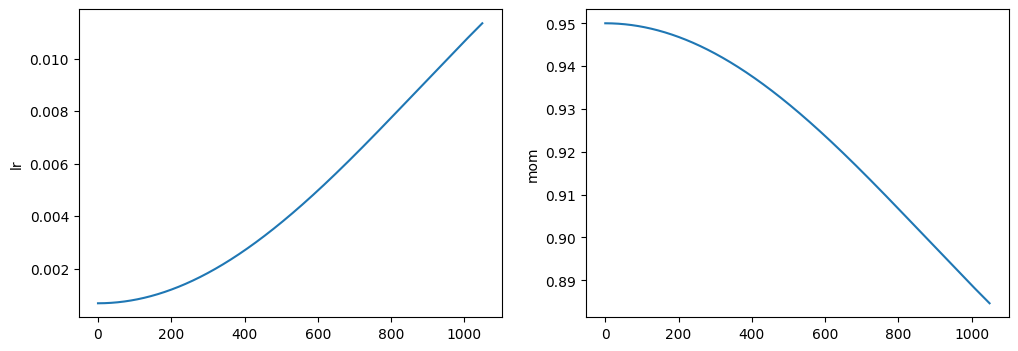

In [ ]:
learn.recorder.plot_sched()  # Visualize learning rate schedule

###Unfreeze the Model:
First, unfreeze all the layers so that they can be updated during training

In [ ]:
learn.unfreeze()  # Allows all layers to be fine-tuned

Now, all layers will be trained instead of just the last ones.



###Train with a Lower Learning Rate:
Now, train the model for 20 epochs using a lower learning rate

In [ ]:
learn.fit_one_cycle(
    20, slice(1e-4, 1e-3),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

epoch,train_loss,valid_loss,accuracy,time
0,0.240576,0.212170,0.925517,00:45
1,0.205908,0.194996,0.930862,00:46
2,0.177698,0.190902,0.930506,00:47
3,0.185343,0.187896,0.931932,00:48
4,0.175820,0.183700,0.932288,00:50
5,0.165402,0.184301,0.935495,00:48
6,0.152409,0.177621,0.934426,00:47
7,0.145312,0.178436,0.935852,00:48
8,0.153322,0.179654,0.936921,00:48
9,0.147509,0.178809,0.937634,00:47


No improvement since epoch 11: early stopping


###Generate the Confusion Matrix
A Confusion Matrix is a great way to validate model performance and understand where the model is making mistakes.

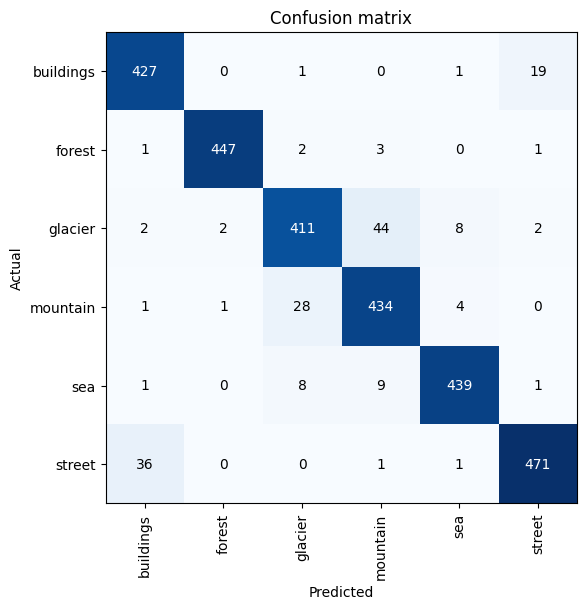

In [ ]:
from fastai.interpret import ClassificationInterpretation

# Generate predictions and confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)


###Check the Most Misclassified Images

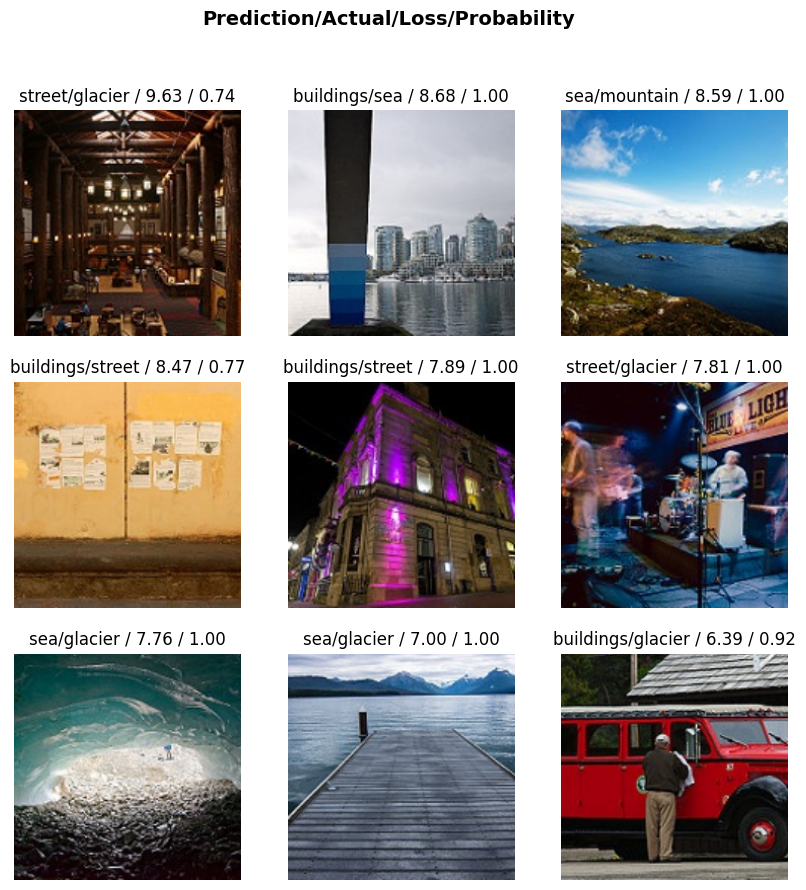

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))

###Prediction Using Trained Model

<Axes: title={'center': 'Prediction: sea (1.0000)'}>

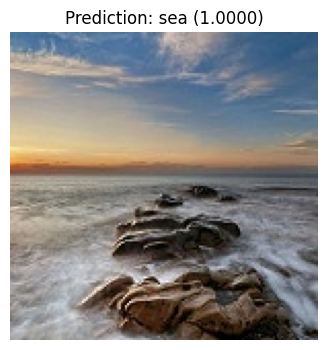

In [ ]:
# 📌 Load an image from test data
img = PILImage.create("/content/intel_dataset/seg_test/seg_test/sea/20099.jpg")  # Change the path to any test image

# 📌 Make a prediction
pred_class, pred_idx, probs = learn.predict(img)

# 📌 Display the image with the predicted class
img.show(title=f"Prediction: {pred_class} ({probs[pred_idx]:.4f})")


###Additional Predictions on Random Test Images

<Axes: title={'center': 'Prediction: sea (1.0000)'}>

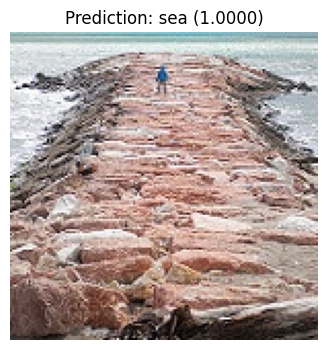

In [ ]:
import random
from pathlib import Path

# 📌 Select a random test image
test_path = Path("/content/intel_dataset/seg_test/seg_test")
random_img_path = random.choice(list(test_path.glob("*/*.jpg")))  # Random image from test dataset

# 📌 Load and predict the random image
img = PILImage.create(random_img_path)
pred_class, pred_idx, probs = learn.predict(img)

# 📌 Display the result
img.show(title=f"Prediction: {pred_class} ({probs[pred_idx]:.4f})")


###Save the Trained Model

In [ ]:
# 📌 Save the trained model
learn.save('intel_image_classifier')


Path('/content/models/intel_image_classifier.pth')

In [ ]:
# 📌 List available saved models
learn.path.ls()

(#5) [Path('.config'),Path('intel_dataset'),Path('archive.zip'),Path('models'),Path('sample_data')]

In [ ]:
# 📌 Load the saved model
learn.load('intel_image_classifier')

###Verify Model Performance After Loading

In [ ]:
# 📌 Select an image and make a prediction
img = PILImage.create("/content/intel_dataset/seg_test/seg_test/sea/20037.jpg")  # Change path to any image

pred_class, pred_idx, probs = learn.predict(img)
img.show(title=f"Prediction: {pred_class} ({probs[pred_idx]:.4f})")

###Export the Model

In [ ]:
# 📌 Export the trained model
learn.export('intel_image_classifier.pkl')

# 📌 Download the exported model
files.download('/content/models/intel_image_classifier.pkl')
